In [71]:
%pylab inline
from __future__ import print_function, division

import os
import os.path as osp
import matplotlib.pyplot as plt

from warnings import warn
import datetime, time
import glob as gb
from six import string_types
import argparse
import json
import time
import re

import numpy as np
#import numpy.linalg as lin
#import scipy.linalg as lin
import scipy.stats as sst

import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [72]:
import smpce_data_to_corr as smp
import layout as lo
import utils._utils as ucr
import correlation2results as c2r
import signals2results as s2r

In [73]:
np.set_printoptions(precision=3)
lo = reload(lo)
ucr = reload(ucr)
smp = reload(smp)
c2r = reload(c2r)
s2r = reload(s2r)

## Read the signals, form a correlation matrix

In [74]:
# get the list of npz corresponding to a specific analysis
# use directory layout for this 
dbase = '/home/jb/data/simpace/rename_files'
pipelines = [None, 'NR_0', 'NR_1', 'NR_2', 'NR_3', 'NR_4', 'NR_5', 'NR_6', 'WMr']
pipeline_dic = {'NR_0':'m_CSF+WM', 
                'NR_1':'m_CSF+WM+GS', 
                'NR_2':'pc_CSF+WM', 
                'NR_3':'pc_CSF+WM+GS', 
                'NR_4':'Filt-only',
                'NR_5':'HPF+CCor',
                'NR_6':'HPF+CCor+GS', 
                'WMr':'WMlocal'}
assert s2r.test_get_npz_filenames(dbase)
assert s2r.test_get_conds_filenames(dbase, pipelines)
ordered_conds = s2r.ordered_conds()

np.set_printoptions(precision=3)

order_pipe = ['NR_4', 'NR_0', 'NR_1', 'NR_2', 'NR_3', 'NR_5', 'NR_6', 'WMr']
order_nicepipe = [pipeline_dic[p] for p in order_pipe]

### Testing getting data from pipeline

In [75]:
a = np.random.normal(0,1,size=(10,5))
np.linalg.norm(a, axis=1)

array([ 2.69 ,  2.277,  1.788,  1.226,  2.863,  1.27 ,  1.565,  2.292,
        2.923,  2.59 ])

In [76]:
def abs_mean(arr):
    return np.mean(np.abs(arr),axis=1)

def abs_median(arr):
    return np.median(np.abs(arr),axis=1)


def eucl_norm(arr):
    return np.linalg.norm(arr, axis=1)

#def pos_75(arr):
#    return np.percentile(np.abs(arr), 75, axis=1)

def pos_75(arr):
    """
    take the quant quantile of the positive values,
    take the quant quantile of the negative values
    return the average of these two 
    """
    quant = 50
    pos_75 = []
    neg_75 = []
    sess, npairs = arr.shape
    # print(arr.shape)
    nbp0 = 0
    nbn0 = 0
    for sidx in range(sess):
        sarr = arr[sidx,:]
        pos = sarr[sarr > 0.]
        neg = sarr[sarr < 0.]
        try:
            pos_75.append(np.percentile(pos, quant))
        except:
            pos_75.append(0.)
            nbp0 += 1
        try:
            neg_75.append(np.percentile(np.abs(neg), quant))
        except:
            neg_75.append(0.)
            nbn0 += 1
    
    if nbp0 != 0 or nbn0 != 0:
        print('added ', nbp0, ' pzeros ', nbn0, ' nzeros')
    
    #print(len(pos_75))
    return (np.asarray(pos_75) + np.asarray(neg_75))/2.




In [77]:

def do_one_pipe(dbase, pipe, pipeline_dic):
    
    conds_files, pipeline = s2r.get_conds_filenames(dbase, addjson=pipe, 
                                                    pipeline_dic=pipeline_dic)
    common_labels = s2r._get_common_labels(conds_files, idx0=1)
    conds_arr, stored_params = s2r.compute_corr_mtx(conds_files, common_labels)
    # print([(k,conds_arr[k].shape) for k in ordered_conds])
    labels = conds_arr['labels']
    conds_arr.pop('labels')

    # --- fisher transform ----
    zconds_arr = s2r.conds_2_zconds(conds_arr, ordered_conds)
    # print([(k,zconds_arr[k].shape) for k in ordered_conds])
    # --- remove none condition from others 
    zconds_minus_none = s2r.remove_cond(zconds_arr, ordered_conds, remove='none')
    # print('zconds_minus_none.keys', zconds_minus_none.keys())
    # --- compute mean of absolute values 
    zconds_abs_mean = s2r.summary_per_zconds(zconds_minus_none, abs_mean)
    nd_zconds_abs_mean = s2r.summary_per_zconds(zconds_arr, abs_mean)
    #
    zconds_eucl_norm = s2r.summary_per_zconds(zconds_minus_none, eucl_norm)
    
    zconds_pos_75 = s2r.summary_per_zconds(zconds_minus_none, pos_75)
    nd_zconds_pos_75 = s2r.summary_per_zconds(zconds_arr, pos_75)
    zconds_abs_median = s2r.summary_per_zconds(zconds_minus_none, abs_median)
    nd_zconds_abs_median = s2r.summary_per_zconds(zconds_arr, abs_median)
    
    corr_none = s2r.summary_correlation(zconds_arr)
    #print(corr_none)
    abs_median
    
    nd_std = {}
    std_diff = {}
    for c in ordered_conds:
        # --- std across sessions : axis=0, then mean/median across npairs
        nd_std[c] = np.median(np.std(zconds_arr[c], axis=0))
        std_diff[c] = np.median(np.std(zconds_minus_none[c], axis=0))
        
        to_print = "cond:{0:5s} bias: {1:5.3f}({2:04.3f}) std: {3:04.3f} corr {4:5.3f}({5:04.3f})"
        print(to_print.format(c, zconds_abs_mean[c].mean(), zconds_abs_mean[c].std(), 
                              nd_std[c], corr_none[c].mean(), corr_none[c].std()))
    
    return({'abs_mean':zconds_abs_mean, 
            'nd_abs_mean':nd_zconds_abs_mean,
            'abs_median': zconds_abs_median,
            'nd_abs_median': nd_zconds_abs_median,
            'corr_none':corr_none, 
            'nd_std':nd_std, 
            'std_diff':std_diff, 
            'nd_pos_75':nd_zconds_pos_75,
            'pos_75':zconds_pos_75,
            'eucl_norm':zconds_eucl_norm })
    

In [78]:
all_pipes = pipelines[1:]
pipe_res = {}
for pipe in all_pipes:
    pipe_res[pipeline_dic[pipe]] = do_one_pipe(dbase, pipe, pipeline_dic)

measures = pipe_res[pipeline_dic[pipe]].keys()
print(measures)

added  13  pzeros  13  nzeros
cond:none  bias: 0.000(0.000) std: 0.204 corr 1.000(0.000)
cond:low   bias: 0.223(0.019) std: 0.190 corr 0.642(0.059)
cond:med   bias: 0.252(0.056) std: 0.225 corr 0.606(0.081)
cond:high  bias: 0.250(0.023) std: 0.183 corr 0.527(0.067)
added  13  pzeros  13  nzeros
cond:none  bias: 0.000(0.000) std: 0.196 corr 1.000(0.000)
cond:low   bias: 0.235(0.020) std: 0.187 corr 0.625(0.054)
cond:med   bias: 0.234(0.020) std: 0.184 corr 0.609(0.071)
cond:high  bias: 0.244(0.014) std: 0.168 corr 0.533(0.053)
added  13  pzeros  13  nzeros
cond:none  bias: 0.000(0.000) std: 0.208 corr 1.000(0.000)
cond:low   bias: 0.236(0.021) std: 0.201 corr 0.592(0.066)
cond:med   bias: 0.242(0.044) std: 0.201 corr 0.577(0.095)
cond:high  bias: 0.252(0.016) std: 0.187 corr 0.512(0.061)
added  13  pzeros  13  nzeros
cond:none  bias: 0.000(0.000) std: 0.202 corr 1.000(0.000)
cond:low   bias: 0.239(0.014) std: 0.199 corr 0.608(0.050)
cond:med   bias: 0.232(0.021) std: 0.189 corr 0.612(0.

In [79]:
pipe_res['WMlocal']['nd_pos_75']

{'high': array([ 0.254,  0.226,  0.165,  0.256,  0.275,  0.186,  0.28 ,  0.217,
         0.276,  0.232,  0.2  ,  0.25 ,  0.198]),
 'low': array([ 0.247,  0.19 ,  0.242,  0.292,  0.257,  0.206,  0.249,  0.172,
         0.221,  0.258,  0.267,  0.237,  0.24 ]),
 'med': array([ 0.361,  0.209,  0.232,  0.251,  0.271,  0.195,  0.291,  0.231,
         0.231,  0.187,  0.334,  0.293,  0.184]),
 'none': array([ 0.229,  0.205,  0.272,  0.238,  0.269,  0.227,  0.219,  0.232,
         0.243,  0.238,  0.252,  0.235,  0.244])}

In [80]:
import collections

def plot_summary(pipe_res, cond, mkey, order=order_nicepipe, nsess=13):
    
    all_pipes = pipe_res.keys()
    data_dic = {}
    data_dic['pipelines'] = []
    data_dic[mkey] = []
    
    for pipe in all_pipes:
        # nicepipe = pipeline_dic[pipe]
        try:
            data_dic[mkey] += list(pipe_res[pipe][mkey][cond])
            data_dic['pipelines'] += [pipe]*nsess

        except:
            # print(pipe_res[pipe][mkey][cond])
            data_dic[mkey] += [pipe_res[pipe][mkey][cond]]
            data_dic['pipelines'] += [pipe]
            
    # data_dic['abs_mean']
    # data_dic['pipelines']

    this_pd = pd.DataFrame.from_dict(data_dic, orient='columns') # , dtype=formats)
    plt.subplots_adjust(top=0.9)
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax_ = sns.boxplot(x="pipelines", y=mkey, data=this_pd, palette="PRGn", ax=ax1, order=order)
    ax_.set_title(cond)
    
    return fig

#axes = plot_summary(pipe_res, cond, mkey)
#type(fig)


In [82]:
print(measures)


['nd_std', 'pos_75', 'corr_none', 'nd_abs_mean', 'nd_pos_75', 'nd_abs_median', 'eucl_norm', 'std_diff', 'abs_mean', 'abs_median']


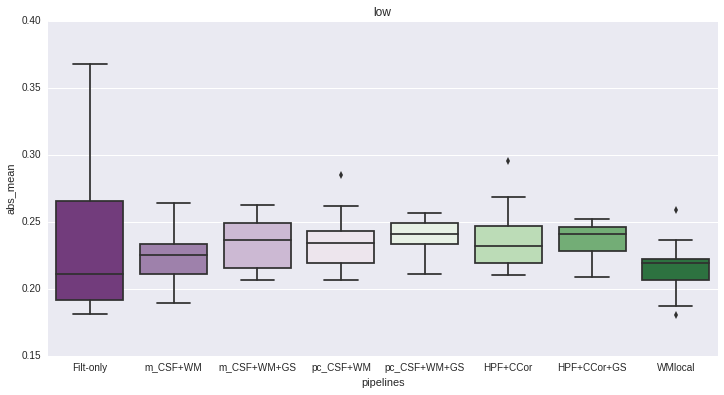

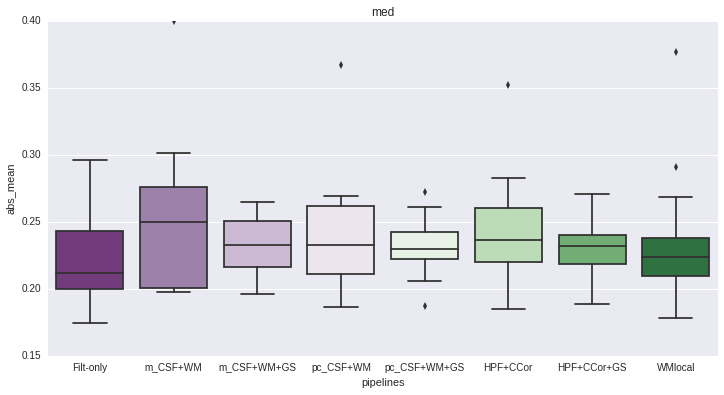

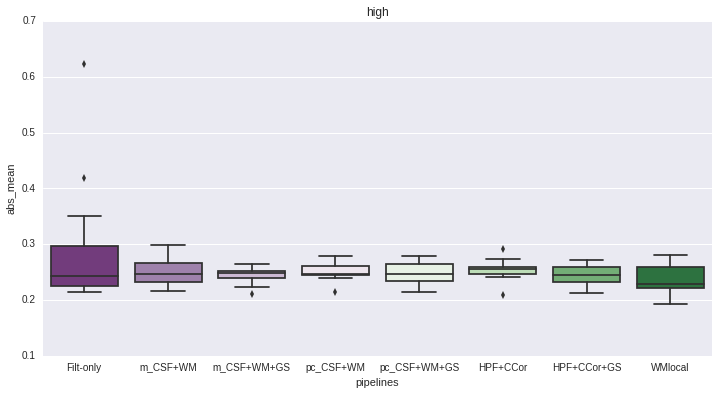

In [84]:
mkey = 'abs_mean'
for cond in ordered_conds:
    if 'nd_' not in mkey:
        if cond != 'none': axes = plot_summary(pipe_res, cond, mkey)
    else:
        axes = plot_summary(pipe_res, cond, mkey)


In [15]:
"""
np.set_printoptions(precision=3)


ordered_conds = s2r.ordered_conds()
ordered_pipelines = [None, 'NR_4', 'NR_0', 'NR_1', 'NR_2', 'NR_3', 'NR_5', 'NR_6', 'WMr']

assert s2r.test_npz_files(dbase, pipelines, nsess=13, ncond=4)

for pipe in ordered_pipelines:
    conds, pipeline = s2r.create_conds_filenames(dbase, addjson=pipe, pipeline_dic=pipeline_dic)
    common_labels = s2r._get_common_labels(conds, idx0=1)
    conds_arr, stored_params = s2r.compute_corr_mtx(conds, common_labels)
    bias, stdev = s2r.smpce_bias_std(conds_arr, ordered_conds)

    print('pipeline:', pipeline)
    print('-'*77)
    for k in ordered_conds:
        #bias, std = s2r.smpce_mean_cond(conds_arr, k)
        avrg = conds_arr[k].mean(axis=0)
        to_print = "{0:5s}: {1:5.2f} mean: {2:03.2f} mean(abs): {3:04.3f} " +  \
                    "std(norm): {4:5.2f} std(mean) {5:5.3f}"
        print(to_print.format(
                k,  lin.norm(bias[k]), avrg.mean(), np.abs(avrg).mean(), 
                    lin.norm(stdev[k]), stdev[k].mean()))
        #print('check', vari[k][[1,2,3,4],[1,2,3,4]]) #  bias[k].shape,
    print("\n")
"""
pass

In [16]:
ordered_conds

['none', 'low', 'med', 'high']

<matplotlib.colorbar.Colorbar instance at 0x7ff18c54bd40>

/home/jb/.virtualenvs/py2/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


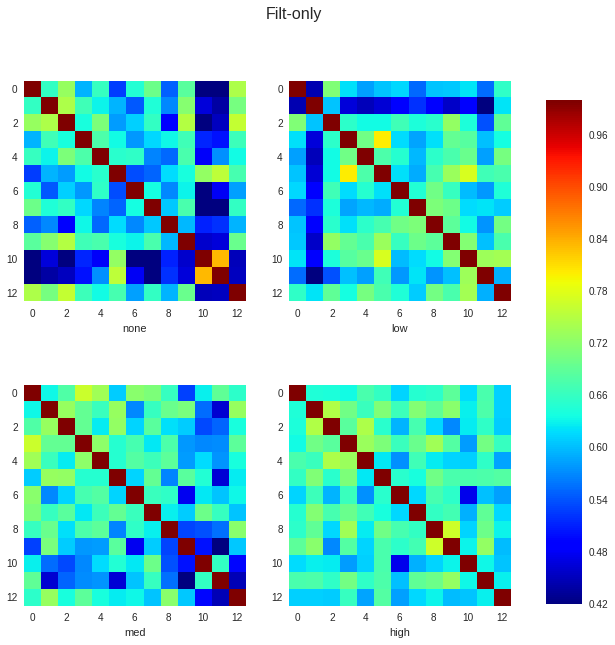

In [17]:
pipe = 'NR_4'
cond='low'
conds_files, pipeline = s2r.get_conds_filenames(dbase, addjson=pipe, 
                                                pipeline_dic=pipeline_dic)
common_labels = s2r._get_common_labels(conds_files, idx0=1)
conds_arr, stored_params = s2r.compute_corr_mtx(conds_files, common_labels)

fig, axes = plt.subplots(2,2, figsize=(10,10))
fig.suptitle(pipeline_dic[pipe], fontsize=16)



axes.shape
#print([a for a in axes.flatten()])
#for idx,(i,j) in enumerate([(0,0), (0,1), (1,0), (1,1)]):
for idx, ax in enumerate(axes.flatten()):
    cond = ordered_conds[idx]
    c = s2r.smpce_corr_btw_sess_cond(conds_arr[cond])
    img = ax.imshow(c,interpolation='nearest', cmap='jet', vmin=.42, vmax=1.)
    #fig.colorbar(img)
    ax.axes.grid(False)
    ax.axes.set_xlabel(cond)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax)
#print(pipe)



Pipeline: Filt-only --- Condition: high


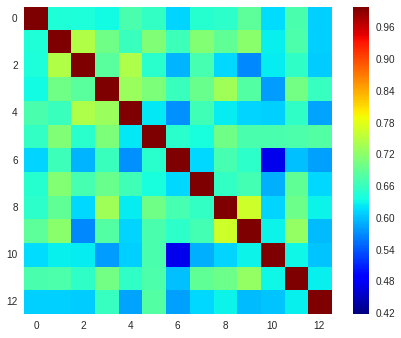

In [18]:
c = s2r.smpce_corr_btw_sess_cond(conds_arr[cond])
ax = plt.imshow(c,interpolation='nearest', cmap='jet', vmin=.42, vmax=1.)
ax.axes.grid(False)
plt.colorbar()
print('Pipeline:', pipeline, '--- Condition:', cond)

In [19]:

def plot_pipeline_summary(conds_summary, title, pipeline=None, minall=-.4, maxall=.4):

    f, axes = plt.subplots(1, 4, sharey=True, figsize=(18,4))
    f.subplots_adjust(wspace=0.1)
    f.subplots_adjust(right=0.85)
    titlestr = 'Pipeline ' + pipeline + ' - ' + title
    f.suptitle(titlestr, fontsize=24, fontweight='bold', x=.5, y=.01)
    left, bottom, width, height = .87, 0.12, 0.02, 0.77 
    cbar_ax = f.add_axes([left, bottom, width, height])

    minall_ = np.min(np.asarray([conds_summary[k].min() for k in ordered_conds]))
    maxall_ = np.max(np.asarray([conds_summary[k].max() for k in ordered_conds]))
    if not minall: minall=minall_
    if not maxall: maxall=maxall_

    for axe,k in zip(axes,ordered_conds): 
        m = axe.imshow(conds_summary[k], interpolation='nearest',  cmap='jet',  vmin=minall, vmax=maxall)
        axe.axes.grid(False)
        axe.set_title(k, fontsize=20)

    cm = f.colorbar(m, cax=cbar_ax)
    return minall_, maxall_
    

NR_4


(0.0, 0.35895900749440329)

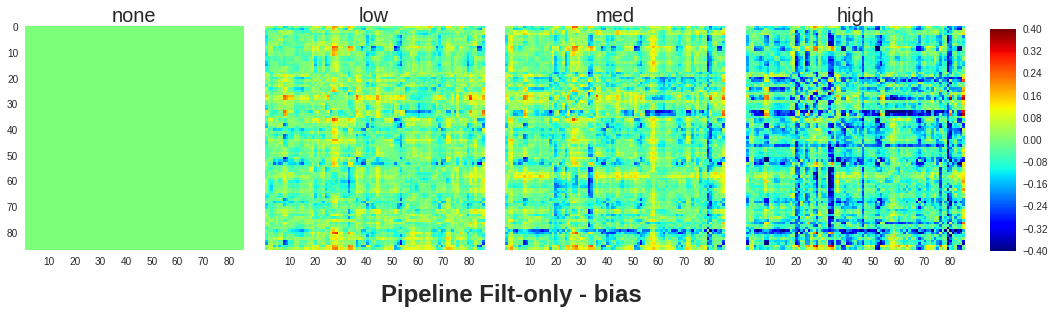

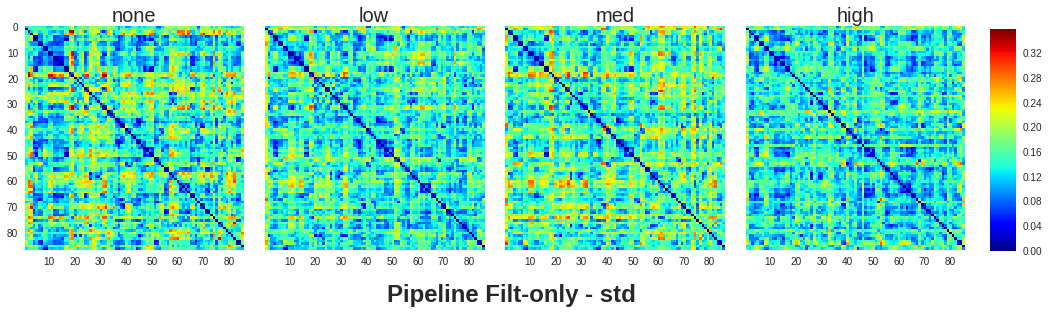

In [21]:
print(pipe)
conds_files, pipeline = s2r.get_conds_filenames(dbase, addjson=pipe, 
                                                pipeline_dic=pipeline_dic)
common_labels = s2r._get_common_labels(conds_files, idx0=1)
conds_arr, stored_params = s2r.compute_corr_mtx(conds_files, common_labels)
# print([(k,conds_arr[k].shape) for k in ordered_conds])
labels = conds_arr['labels']
conds_arr.pop('labels')

bias, vari = s2r.smpce_bias_std(conds_arr, ordered_conds)

plot_pipeline_summary(bias, 'bias',  pipeline=pipeline)
plot_pipeline_summary(vari, 'std', pipeline=pipeline, minall=None, maxall=None)

In [16]:
"""
for pipe in pipelines:
    conds, pipeline = s2r.create_conds_filenames(dbase, addjson=pipe)
    common_labels = s2r._get_common_labels(conds, idx0=1)
    conds_arr, stored_params = s2r.compute_corr_mtx(conds, common_labels)
"""
pass

In [41]:
def sum_statistic(conds_arr, randomize=False, ordered_conds=s2r.ordered_conds()):
    """ 
    compute per link the sum across session of the difference with "none"
    """
    arr = np.asarray([conds_arr[c] for c in ordered_conds])
    ncond, nsess, nroi, _ = arr.shape
    assert nroi == arr[0].shape[-1]
    # print('---', randomize, ncond, nsess, nroi)

    ind_triu = np.triu_indices(nroi,1)
    atriu = np.asarray(arr[:,:, ind_triu[0], ind_triu[1]])
    npairs = atriu.shape[-1]

    sum_arr = np.zeros((npairs,)) # nb of coefficients
    
    for s in range(nsess):
        if randomize:
            none_cond = np.random.choice([0,1,2,3])
        else:
            none_cond = 0
        sess_arr = (atriu[:,s,:] - atriu[none_cond, s, :]).sum(axis=0)
        sum_arr += sess_arr

    return sum_arr/nsess

In [88]:
def affected_pairs(dbase, pipe, pipeline_dic=pipeline_dic, nsim=1000, verbose=False):
    pipe = "NR_4"
    conds_files, pipeline = s2r.get_conds_filenames(dbase, addjson=pipe, 
                                                        pipeline_dic=pipeline_dic)

    common_labels = s2r._get_common_labels(conds_files, idx0=1)
    conds_arr, stored_params = s2r.compute_corr_mtx(conds_files, common_labels)
    nroi = conds_arr['none'].shape[-1]
    ind_triu = np.triu_indices(nroi,1)
    npairs = ind_triu[0].shape[0]
    #if verbose: print('nroi, npairs:', nroi, npairs)

    arr_p = np.zeros((npairs,nsim), dtype=np.float32)
    for i in range(nsim):
        arr_p[:,i] = sum_statistic(conds_arr, randomize=True)

    arr_nop = sum_statistic(conds_arr, randomize=False)
    #print(arr_p.shape)
    # compute the max and min value across npairs for multiple comparisons (yield a nsim array)
    max_arr_p = arr_p.max(axis=0)
    min_arr_p = arr_p.min(axis=0)
    
    max_cm, min_cm, max_5p, min_5pc = \
        ( sst.percentileofscore(max_arr_p, arr_nop.max()), 
          sst.percentileofscore(min_arr_p, arr_nop.min()), 
         (arr_nop > sst.scoreatpercentile(max_arr_p, 95.)).sum(), 
         (arr_nop < sst.scoreatpercentile(min_arr_p, 5.)).sum())
        
        
    non_corrected_neg = arr_nop < arr_p.mean(axis=1) - 1.64*arr_p.std(axis=1)
    non_corrected_pos = arr_nop > arr_p.mean(axis=1) + 1.64*arr_p.std(axis=1)
    non_corr_neg, pc_non_corr_neg = \
            non_corrected_neg.sum(), non_corrected_neg.sum()/ npairs #arr_nop.shape[0]
    non_corr_pos, pc_non_corr_pos = \
        non_corrected_pos.sum(), non_corrected_pos.sum()/ npairs # arr_nop.shape[0]
    
    if verbose:
        print('max_cm, min_cm, max_5p, min_5pc: \t', max_cm, min_cm, max_5p, min_5pc)
        print('non_corr_neg, pc_non_corr_neg / pos: ', non_corr_neg, pc_non_corr_neg, \
                                                      non_corr_pos, pc_non_corr_pos)
        
    return max_cm, min_cm, max_5p, min_5pc

In [91]:
res_perm = {}
print(pipeline_dic)
print(pipelines)
for pipe in pipelines:
    if pipe:
        print(pipeline_dic[pipe])
        res_perm[pipe] = affected_pairs(dbase, pipe, nsim=3000, verbose=True)


{'NR_1': 'm_CSF+WM+GS', 'NR_0': 'm_CSF+WM', 'NR_3': 'pc_CSF+WM+GS', 'NR_2': 'pc_CSF+WM', 'NR_5': 'HPF+CCor', 'NR_4': 'Filt-only', 'NR_6': 'HPF+CCor+GS', 'WMr': 'WMlocal'}
[None, 'NR_0', 'NR_1', 'NR_2', 'NR_3', 'NR_4', 'NR_5', 'NR_6', 'WMr']
m_CSF+WM
max_cm, min_cm, max_5p, min_5pc: 	 99.0 0.0 4 65
non_corr_neg, pc_non_corr_neg / pos:  1023 0.273456295108 177 0.0473135525261
m_CSF+WM+GS
max_cm, min_cm, max_5p, min_5pc: 	 98.6666666667 0.0 4 65
non_corr_neg, pc_non_corr_neg / pos:  1022 0.273188986902 175 0.0467789361133
pc_CSF+WM
max_cm, min_cm, max_5p, min_5pc: 	 99.1333333333 0.0 4 67
non_corr_neg, pc_non_corr_neg / pos:  1035 0.276663993585 176 0.0470462443197
pc_CSF+WM+GS
max_cm, min_cm, max_5p, min_5pc: 	 98.8666666667 0.0 4 68
non_corr_neg, pc_non_corr_neg / pos:  1052 0.281208233093 178 0.0475808607324
Filt-only
max_cm, min_cm, max_5p, min_5pc: 	 98.8333333333 0.0 4 70
non_corr_neg, pc_non_corr_neg / pos:  1037 0.277198609997 176 0.0470462443197
HPF+CCor
max_cm, min_cm, max_5p, m